In [1]:
import os
import pathlib
import pickle

# Third-party
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
import astropy.table as at
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.special import logsumexp
from scipy.optimize import minimize
from numba import jit

from pyia import GaiaData
from gala.mpl_style import laguna, hesperia

from myspace import MySpace

In [2]:
with coord.galactocentric_frame_defaults.set('v4.0'):
    gc_frame = coord.Galactocentric()

In [3]:
# filename = '../data/rv-good-plx.fits'
# filename = '/Users/apricewhelan/data/GaiaDR2/rv-good-plx.fits'
filename = '/mnt/home/apricewhelan/data/GaiaDR2/rv-2mass.fits'
g = GaiaData(filename)

ebv = g.get_ebv()

ph_qual = np.array(g.ph_qual).astype(str)
g = g[(g.parallax > 0.25*u.mas) & 
      np.char.startswith(ph_qual, 'AAA') & 
      (ebv < 1.) &
      (g.ruwe < 1.4)]

c = g.skycoord
galcen = c.transform_to(gc_frame)
ebv = g.get_ebv()
len(g)

1418093

In [4]:
gal = c.galactic
gal.set_representation_cls('cartesian')

Reddening corrections for 2MASS:

In [5]:
ebv_to_A = {
    "J": 0.72,
    "H": 0.46,
    "Ks": 0.306
}
ebv = g.get_ebv()
A_color = ebv * (ebv_to_A['J'] - ebv_to_A['Ks']) * u.mag
A_mag = ebv * ebv_to_A['H'] * u.mag

In [6]:
color = g.j_m - g.ks_m + np.random.uniform(size=len(g)) * 1e-3*u.mag - A_color
mag = g.h_m - g.distmod - A_mag

Load an isochrone to over-plot FGK part:

In [7]:
iso = at.Table.read('/mnt/home/apricewhelan/data/isochrones/mist/FeH_0.0_iso.fits')
iso = iso[(iso['phase'] < 2) &
          (iso['log10_isochrone_age_yr'] == 8.5)]

teff = 10 ** iso['log_Teff']
# fgk_mask = (
#     (iso['log_g'] > 3.4) &
#     (teff > 3700) &  # K (thanks wikipedia)
#     (teff < 7500))   # F
fgk_mask = (
    (iso['log_g'] > 3.4) &
    (teff > 4000) &  # K (tightened wikipedia)
    (teff < 7000))   # F

afg_mask = (
    (iso['log_g'] > 3.4) &
    (teff > 5200) &  # G
    (teff < 10000))  # F

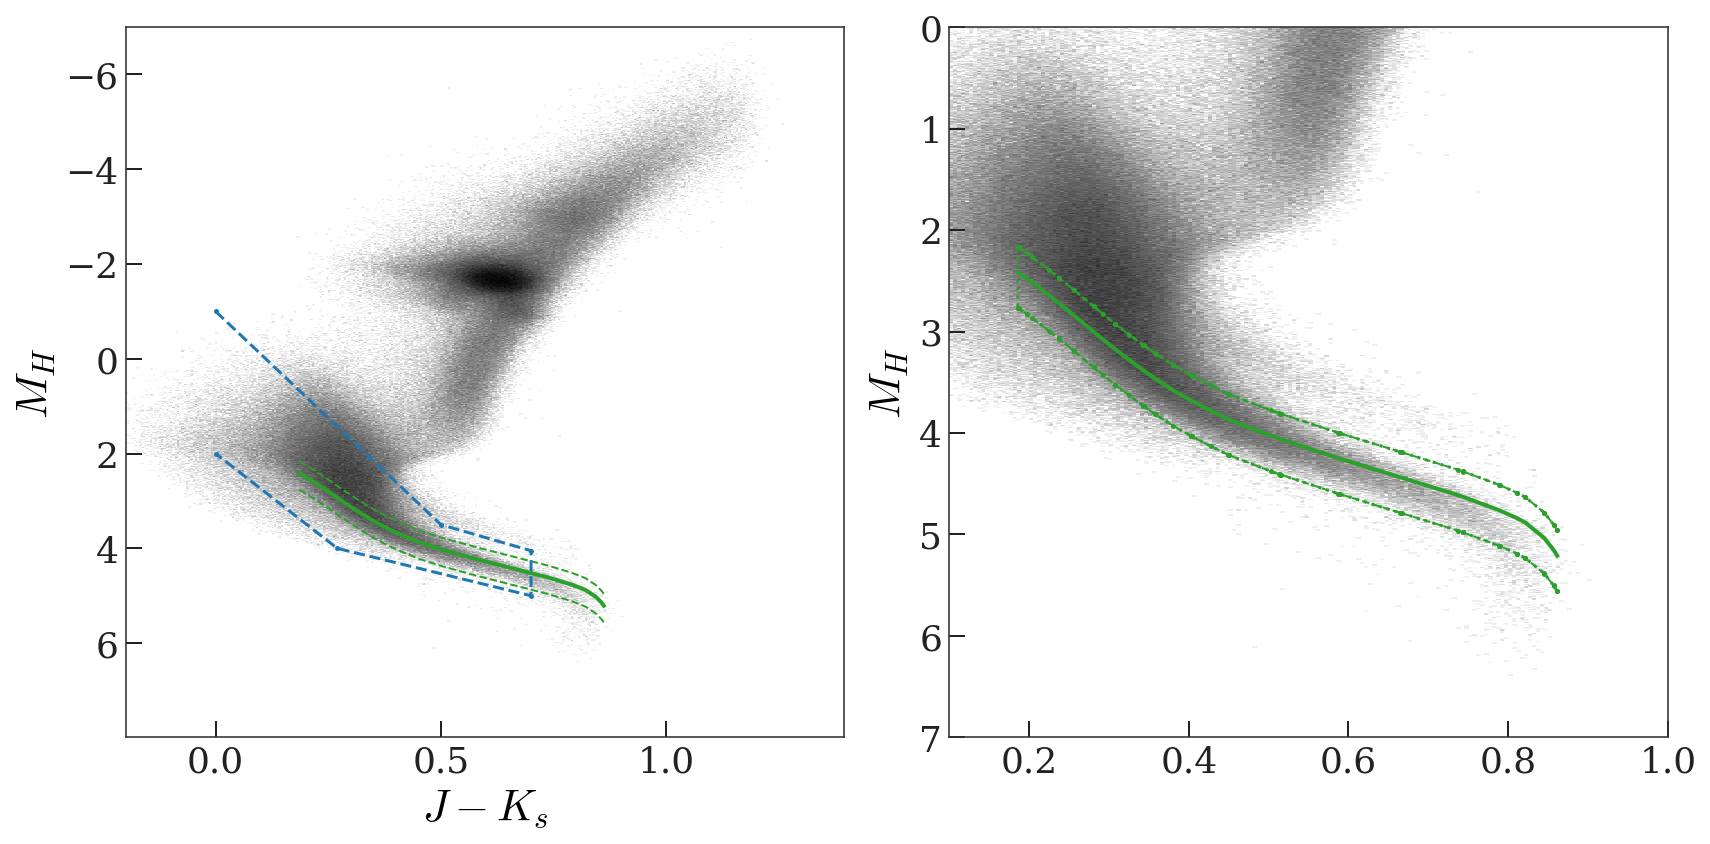

In [8]:
bins = (np.arange(-0.2, 1.4, 0.005),
        np.arange(-7, 8, 0.01))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
ax.hist2d(color.value, mag.value, 
          bins=bins,
          norm=mpl.colors.LogNorm(), cmap='Greys');
ax.set_xlim(bins[0].min(), bins[0].max())
ax.set_ylim(bins[1].max(), bins[1].min())

ax.set_xlabel('$J-K_s$')
ax.set_ylabel('$M_H$')

# ---

ax = axes[1]
ax.hist2d(color.value, mag.value, 
          bins=bins,
          norm=mpl.colors.LogNorm(),
          cmap='Greys');
ax.set_xlim(0.1, 1)
ax.set_ylim(7, 0)

ax.set_ylabel('$M_H$')

for ax in axes:
    ax.plot((iso['J'] - iso['Ks'])[fgk_mask],
            iso['H'][fgk_mask],
            marker='', color='tab:green', lw=2)
    
    ax.plot((iso['J'] - iso['Ks'])[fgk_mask],
            iso['H'][fgk_mask] + 0.35,
            marker='', color='tab:green', lw=1, ls='--')
    
    ax.plot((iso['J'] - iso['Ks'])[fgk_mask],
            iso['H'][fgk_mask] - 0.25,
            marker='', color='tab:green', lw=1, ls='--')

# FGK stars
verts1 = np.stack(((iso['J'] - iso['Ks'])[fgk_mask],
                    iso['H'][fgk_mask] + 0.35)).T
verts2 = np.stack(((iso['J'] - iso['Ks'])[fgk_mask],
                    iso['H'][fgk_mask] - 0.25)).T[::-1]
verts = np.vstack((verts1, verts2))
ax.plot(verts[:, 0], verts[:, 1], color='tab:green', ls=':')
fgk_path = mpl.path.Path(verts)

# Remove the giant branch & lower main sequence
verts = np.array([
    [0, -1], 
    [0.5, 3.5],
    [0.7, 4.05],
    [0.7, 5],
    [0.27, 4],
    [0, 2],
])
axes[0].plot(verts[:, 0], verts[:, 1], color='tab:blue', ls='--')
young_path = mpl.path.Path(verts)

fig.tight_layout()

In [9]:
_X = np.stack((color.value, mag.value)).T
fgk_mask = fgk_path.contains_points(_X)
young_mask = young_path.contains_points(_X)
afg_mask = young_mask & (color.value < 0.5)  # G star mag cut
fgk_mask.sum(), young_mask.sum()

(161525, 498425)

In [10]:
xyz = np.vstack((gal.u.to(u.pc).value, 
                 gal.v.to(u.pc).value,
                 gal.w.to(u.pc).value)).T

UVW = np.vstack((gal.U.to(u.km/u.s).value, 
                 gal.V.to(u.km/u.s).value, 
                 gal.W.to(u.km/u.s).value)).T

disk_vmask = np.linalg.norm(UVW, axis=1) < 200.

In [11]:
_cyl = gal.represent_as('cylindrical')
mask_r100 = (_cyl.rho < 100*u.pc) & (np.abs(_cyl.z) < 150*u.pc)
mask_r300 = (_cyl.rho < 300*u.pc) & (np.abs(_cyl.z) < 500*u.pc)
mask_r500 = (_cyl.rho < 500*u.pc) & (np.abs(_cyl.z) < 500*u.pc)
mask_r100.sum(), mask_r500.sum()

(20302, 428640)

### How far our can we see AFG stars reliably?

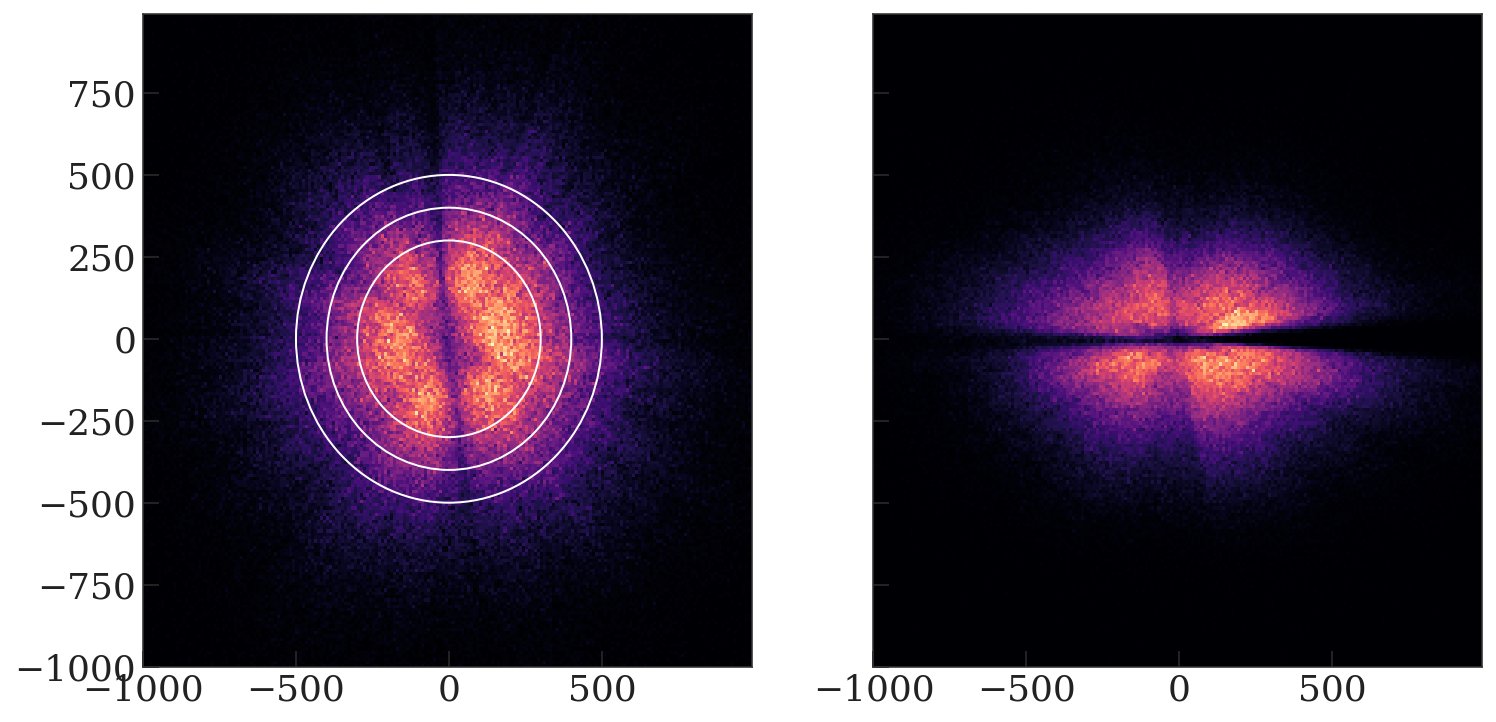

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), 
                         sharex=True, sharey=True)
ax = axes[0]
ax.hist2d(xyz[afg_mask, 0], xyz[afg_mask, 1], 
          bins=np.arange(-1000, 1000, 10))

for r in [300, 400, 500]:
    circ = mpl.patches.Circle(xy=(0,0), radius=r,
                              facecolor='none', edgecolor='w')
    ax.add_patch(circ)

ax.set_xlim(-1000, 1000)
ax.set_ylim(-1000, 1000)

axes[1].hist2d(xyz[afg_mask, 0], xyz[afg_mask, 2], 
               bins=np.arange(-1000, 1000, 10));

### Fit a GMM to the local velocity distribution:

In [13]:
from sklearn.mixture import GaussianMixture

In [14]:
local_v = UVW[disk_vmask & mask_r100 & young_mask]
local_x = xyz[disk_vmask & mask_r100 & young_mask]
len(local_v)

12073

In [15]:
train_mask = np.random.choice([True, False], len(local_v))

X_train = local_v[train_mask]
X_test = local_v[~train_mask]

n_components = 2 ** np.arange(3, 8+1, 1)
gmm_models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_train)
              for n in n_components]

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  """


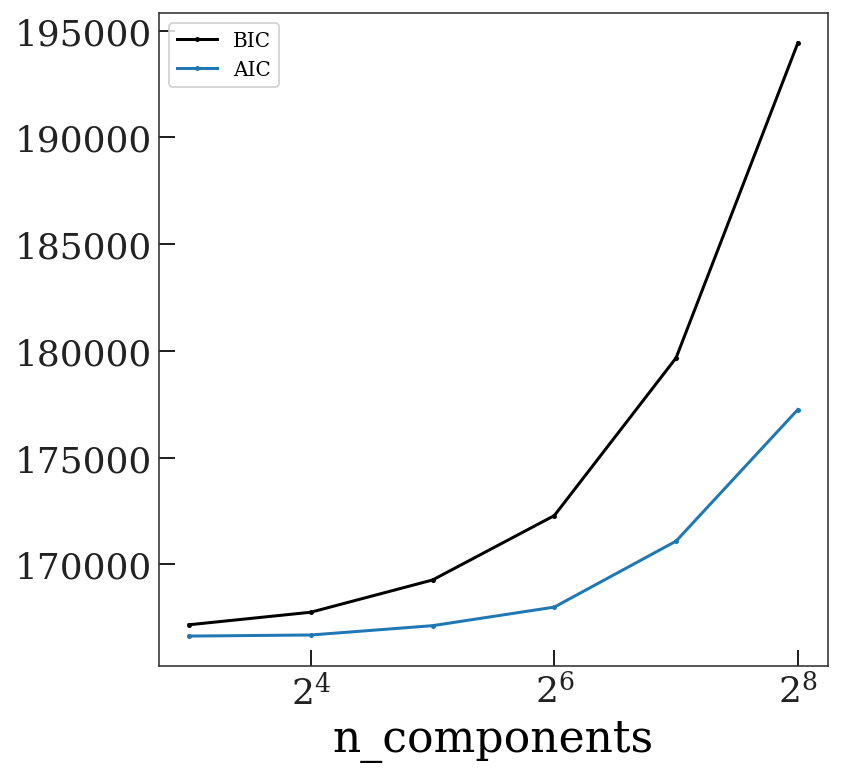

In [16]:
plt.plot(n_components, [m.bic(X_test) for m in gmm_models], label='BIC')
plt.plot(n_components, [m.aic(X_test) for m in gmm_models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');
plt.xscale('log', basex=2)

Train a GMM at the optimal n_components ... times 2 because sure

In [17]:
K = 64

gmm_cache = pathlib.Path(f'../cache/gmm-{K}.pkl')

if not gmm_cache.exists() or True:
    gmm = GaussianMixture(n_components=K, 
                          covariance_type='full', 
                          n_init=32)
    gmm.fit(local_v)
    with open(gmm_cache, 'wb') as f:
        pickle.dump(gmm, f)

else:
    with open(gmm_cache, 'rb') as f:
        gmm = pickle.load(f)

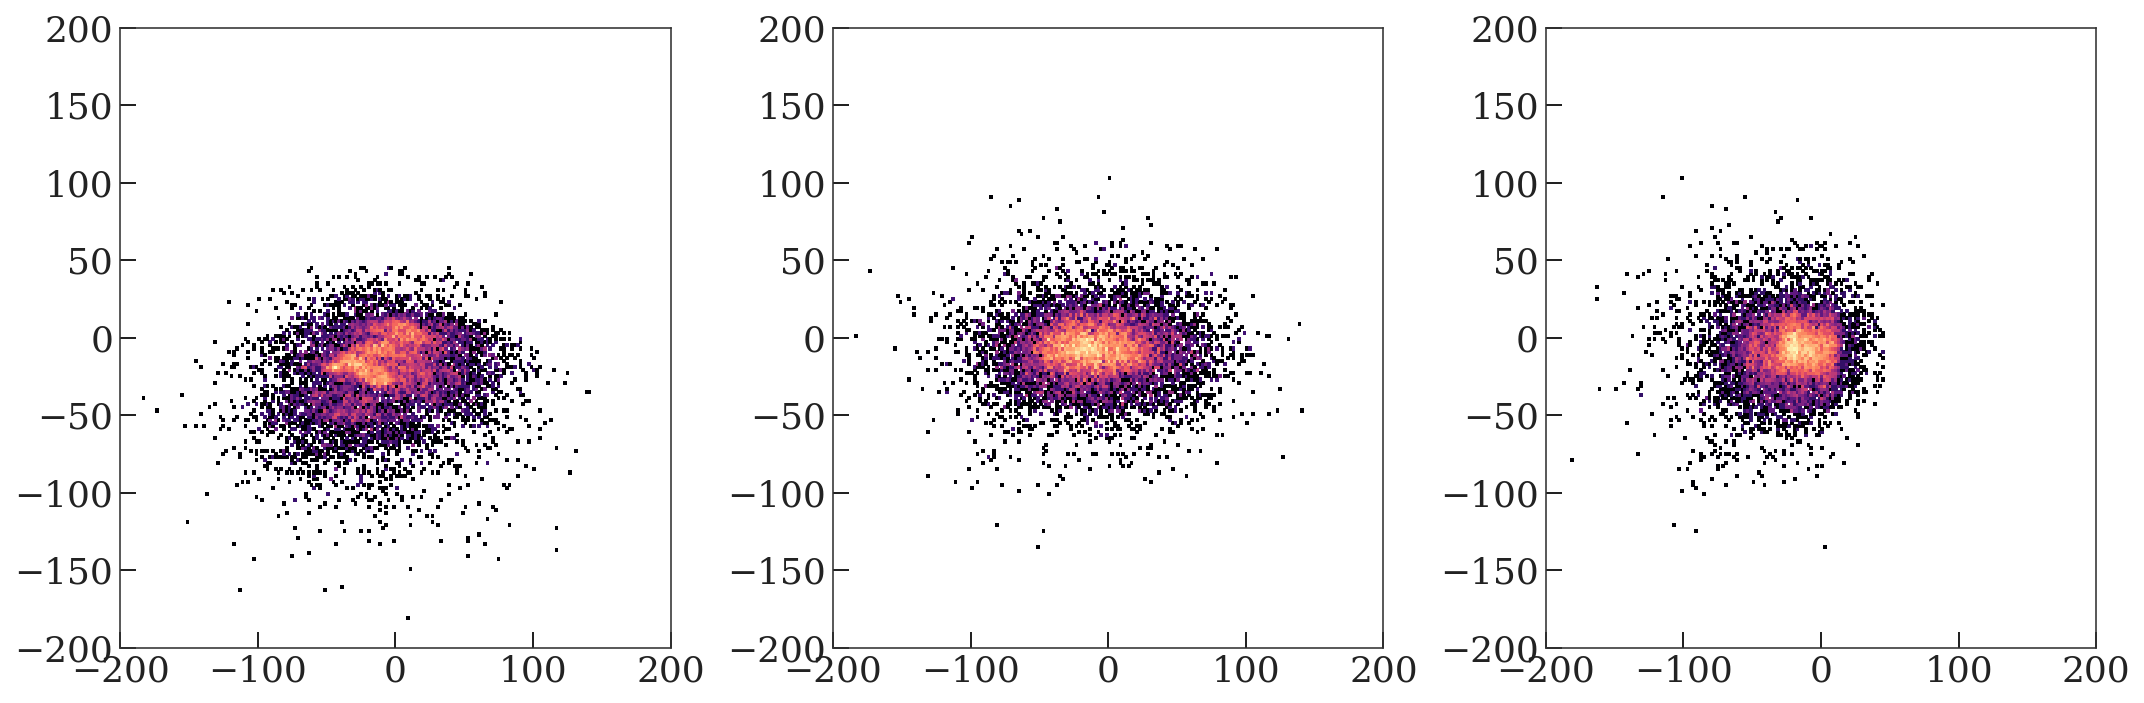

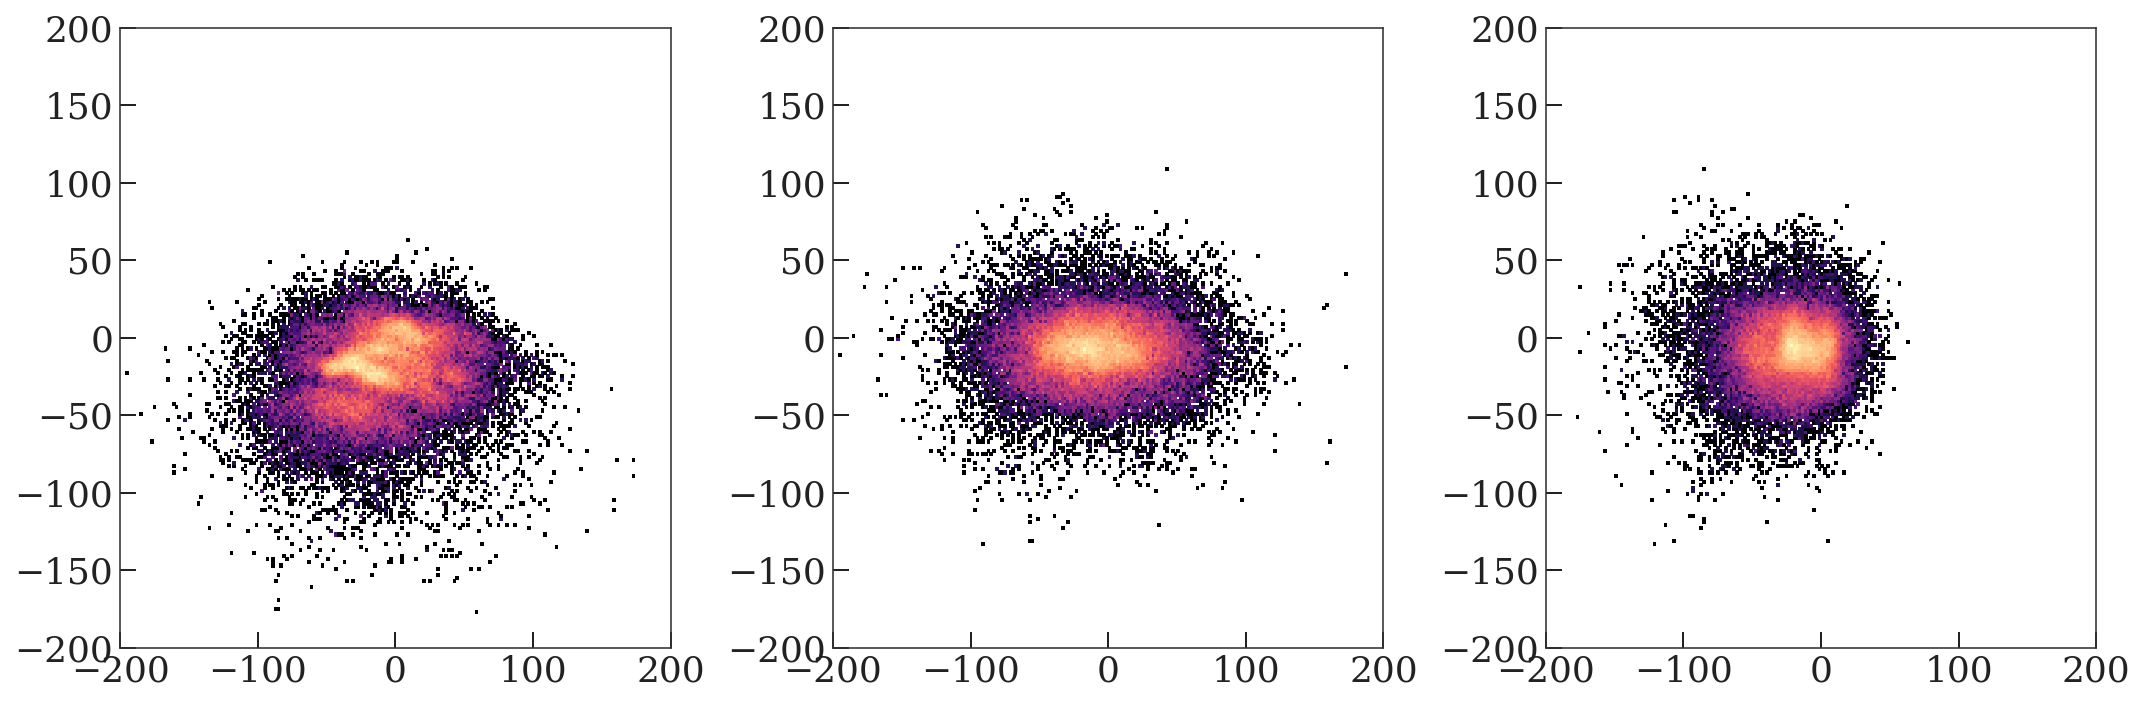

In [18]:
X = local_v

bins = np.arange(-200, 200+1e-3, 2.)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist2d(X[:, 0], X[:, 1], bins=bins, norm=mpl.colors.LogNorm())
axes[1].hist2d(X[:, 0], X[:, 2], bins=bins, norm=mpl.colors.LogNorm())
axes[2].hist2d(X[:, 1], X[:, 2], bins=bins, norm=mpl.colors.LogNorm());
fig.set_facecolor('w')
fig.tight_layout()
        
# ---

# for K in [16, 16*4, 16*4*4]:
# gmm = GaussianMixture(n_components=K, covariance_type='full')
# gmm.fit(local_v[::4])

X, _ = gmm.sample(4 * len(local_v))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist2d(X[:, 0], X[:, 1], bins=bins, norm=mpl.colors.LogNorm())
axes[1].hist2d(X[:, 0], X[:, 2], bins=bins, norm=mpl.colors.LogNorm())
axes[2].hist2d(X[:, 1], X[:, 2], bins=bins, norm=mpl.colors.LogNorm());
fig.set_facecolor('w')
fig.tight_layout()

In [19]:
train_v = UVW[disk_vmask & mask_r300 & fgk_mask]
train_x = xyz[disk_vmask & mask_r300 & fgk_mask]

test_v = UVW[disk_vmask & mask_r500 & young_mask]
test_x = xyz[disk_vmask & mask_r500 & young_mask]

local_v.shape, train_v.shape, test_v.shape

((12073, 3), (111667, 3), (344544, 3))

## Running myspace:

In [20]:
# myspace = MySpace(gmm, terms=['x'])
myspace = MySpace(gmm, terms=['x', 'xv'])

Train on FGK stars, test on broader main sequence:

In [21]:
res, tensors = myspace.fit(train_x, train_v)

In [23]:
tensors

{'Aij': array([[-0.01071947, -0.01909426,  0.00636393],
        [-0.01893421,  0.00054227,  0.00257185],
        [-0.01014634,  0.00299764,  0.00836259]]),
 'Bijl': array([[[-8.43840431e-04,  6.18373708e-04,  6.94123713e-05],
         [ 1.90626423e-04, -6.40588176e-05, -4.65317718e-05],
         [ 5.10137711e-04, -3.72609299e-04,  2.36428954e-04]],
 
        [[ 2.83967365e-04, -5.38066116e-04, -2.33923050e-05],
         [ 4.11557122e-06,  1.41104058e-04,  4.68599884e-05],
         [-1.53391836e-04,  5.37807021e-04, -3.35127574e-05]],
 
        [[ 4.29730127e-05, -1.70859724e-05, -1.38535628e-03],
         [-1.83330197e-05,  2.08411461e-05,  4.55733667e-04],
         [ 3.94959426e-05, -3.16141797e-05,  1.15414888e-03]]])}

In [24]:
print(-tensors['Aij'])

[[ 0.01071947  0.01909426 -0.00636393]
 [ 0.01893421 -0.00054227 -0.00257185]
 [ 0.01014634 -0.00299764 -0.00836259]]


In [25]:
print(-tensors['Bijl'])

[[[ 8.43840431e-04 -6.18373708e-04 -6.94123713e-05]
  [-1.90626423e-04  6.40588176e-05  4.65317718e-05]
  [-5.10137711e-04  3.72609299e-04 -2.36428954e-04]]

 [[-2.83967365e-04  5.38066116e-04  2.33923050e-05]
  [-4.11557122e-06 -1.41104058e-04 -4.68599884e-05]
  [ 1.53391836e-04 -5.37807021e-04  3.35127574e-05]]

 [[-4.29730127e-05  1.70859724e-05  1.38535628e-03]
  [ 1.83330197e-05 -2.08411461e-05 -4.55733667e-04]
  [-3.94959426e-05  3.16141797e-05 -1.15414888e-03]]]


In [26]:
test_pred_v = myspace.get_model_v(tensors, test_v, test_x)

Text(0.5, 1.0, "myspace'd training sample")

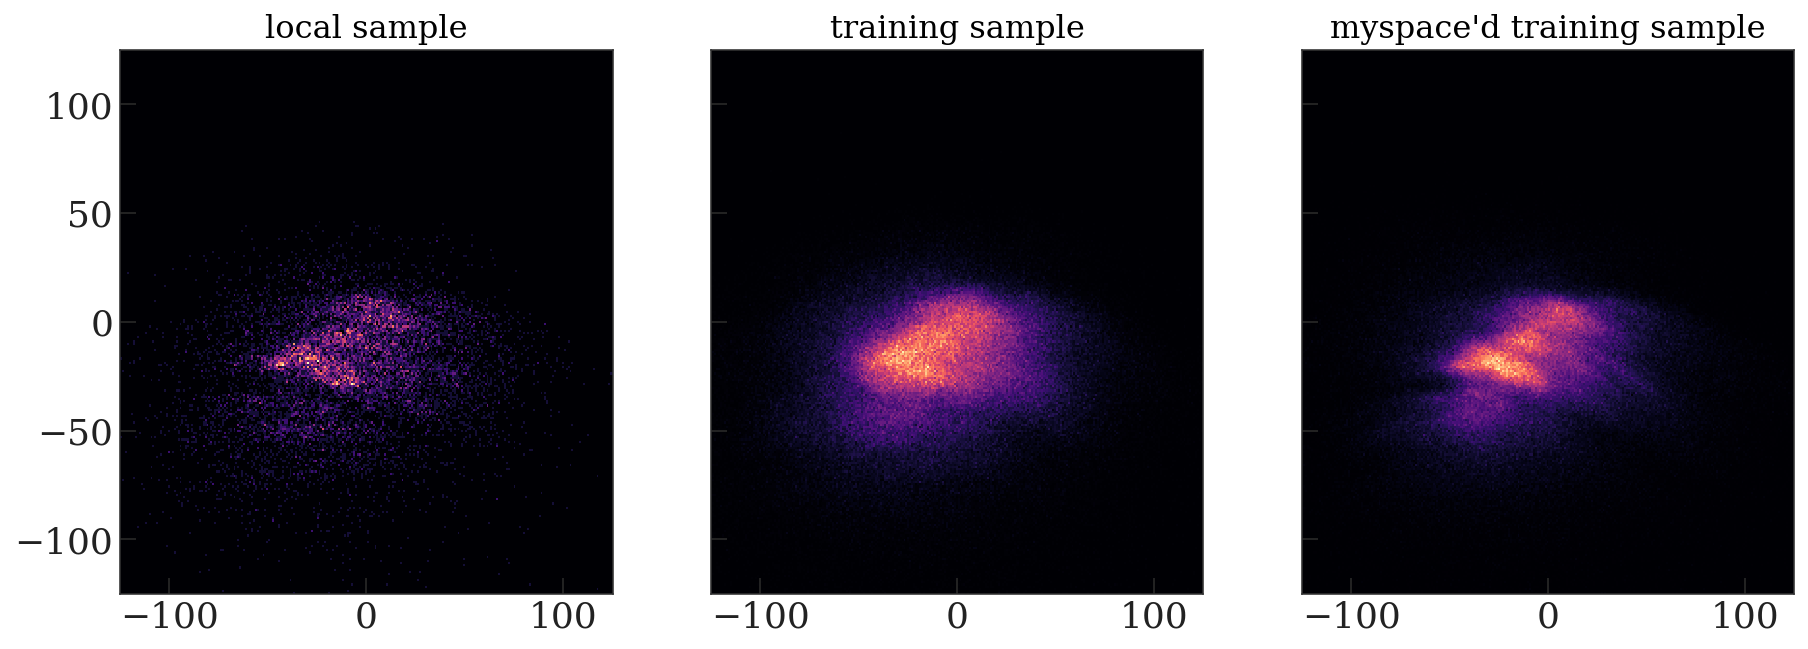

In [31]:
style = dict(marker='o', alpha=0.1, ms=2, ls='none', mew=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5),
                         sharex=True, sharey=True)

bins = np.linspace(-125, 125, 256)
axes[0].hist2d(local_v[:, 0], local_v[:, 1],
               bins=bins)
H1, *_ = axes[1].hist2d(test_v[:, 0], test_v[:, 1], 
                        bins=bins)
H2, *_ = axes[2].hist2d(test_pred_v[:, 0], test_pred_v[:, 1], 
                        bins=bins)

axes[0].set_xlim(-125, 125)
axes[0].set_ylim(-125, 125)

axes[0].set_title('local sample', fontsize=16)
axes[1].set_title('training sample', fontsize=16)
axes[2].set_title("myspace'd training sample", fontsize=16)

bovy gets: A, B, C, K = (15.3, -11.9, -3.2, -3.3) km/s/kpc

In [32]:
Aij = -tensors['Aij']
oort_A = 0.5 * (Aij[0, 1] + Aij[1, 0]) * u.km/u.s / u.pc
oort_B = 0.5 * (Aij[1, 0] - Aij[0, 1]) * u.km/u.s / u.pc
oort_C = 0.5 * (Aij[0, 0] - Aij[1, 1]) * u.km/u.s / u.pc
oort_K = 0.5 * (Aij[0, 0] + Aij[1, 1]) * u.km/u.s / u.pc
oorts = u.Quantity([oort_A, oort_B, oort_C, oort_K])
oorts.to(u.km/u.s/u.kpc)

<Quantity [19.01423485, -0.08002467,  5.63087321,  5.08860031] km / (kpc s)>

### Apply to all stars:

In [33]:
all_v_model = myspace.get_model_v(tensors, UVW, xyz)

In [34]:
R_mask = (np.sqrt(xyz[:, 0]**2 + xyz[:, 1]**2) < 750.) & (np.abs(xyz[:, 2]) < 500)
close_mask = (np.sqrt(xyz[:, 0]**2 + xyz[:, 1]**2) < 150.) & (np.abs(xyz[:, 2]) < 200)

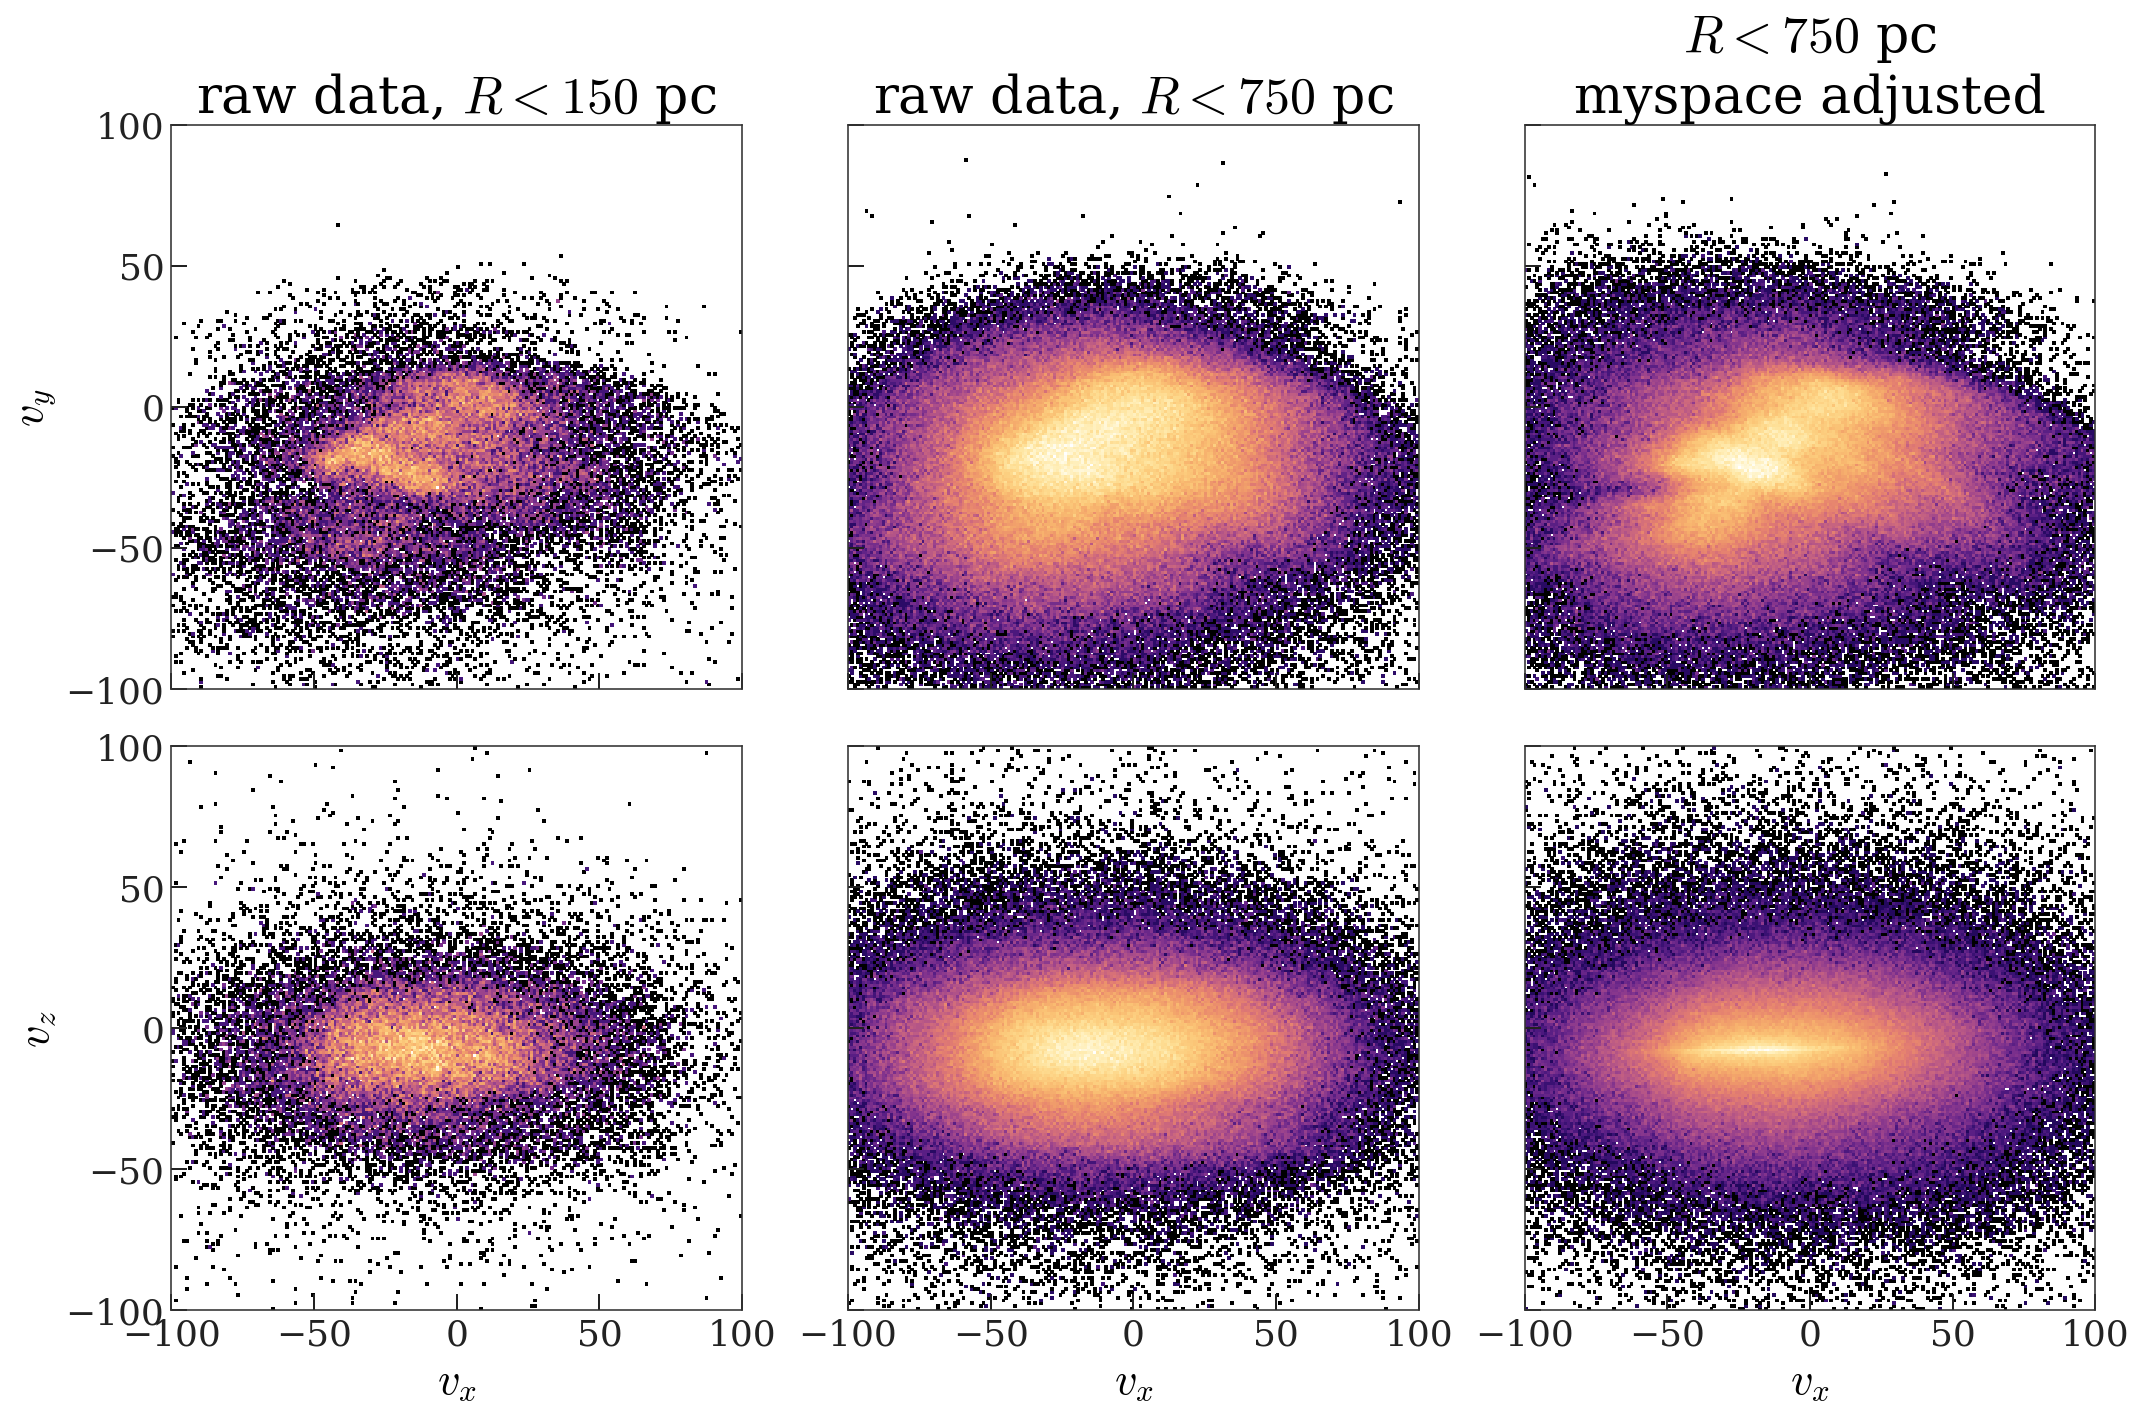

In [35]:
fig, all_axes = plt.subplots(2, 3, figsize=(15, 10),
                             sharex=True, sharey=True)

bins = np.arange(-100, 100+1e-3, 1)
style = dict(cmap='hesperia')

axes = all_axes[0]

for i, j in zip([0, 1], 
                [1, 2]):
    axes = all_axes[i]
    
    for k, (mask, v_sample) in enumerate(zip([close_mask, R_mask, R_mask],
                                             [UVW, UVW, all_v_model])):
        H, xe, ye = np.histogram2d(v_sample[mask & young_mask, 0], 
                                   v_sample[mask & young_mask, j],
                                   bins=bins)
        axes[k].pcolormesh(xe, ye, H.T, norm=mpl.colors.LogNorm(), **style)

all_axes[0, 0].set_title('raw data, $R < 150$ pc')
all_axes[0, 1].set_title('raw data, $R < 750$ pc')
all_axes[0, 2].set_title('$R < 750$ pc\nmyspace adjusted')
all_axes[0, 0].set_ylabel('$v_y$')

all_axes[1, 0].set_xlabel('$v_x$')
all_axes[1, 1].set_xlabel('$v_x$')
all_axes[1, 0].set_ylabel('$v_z$')
all_axes[1, 2].set_xlabel('$v_x$')

fig.tight_layout()
fig.set_facecolor('w')

### Blink and difference histograms:

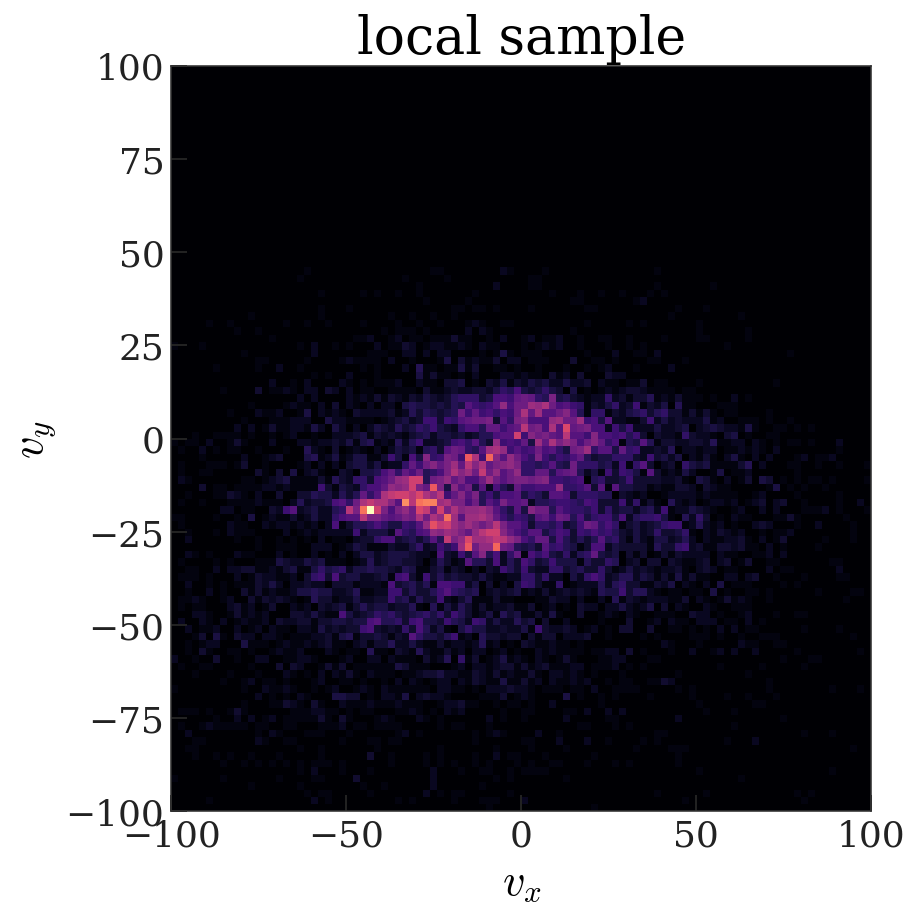

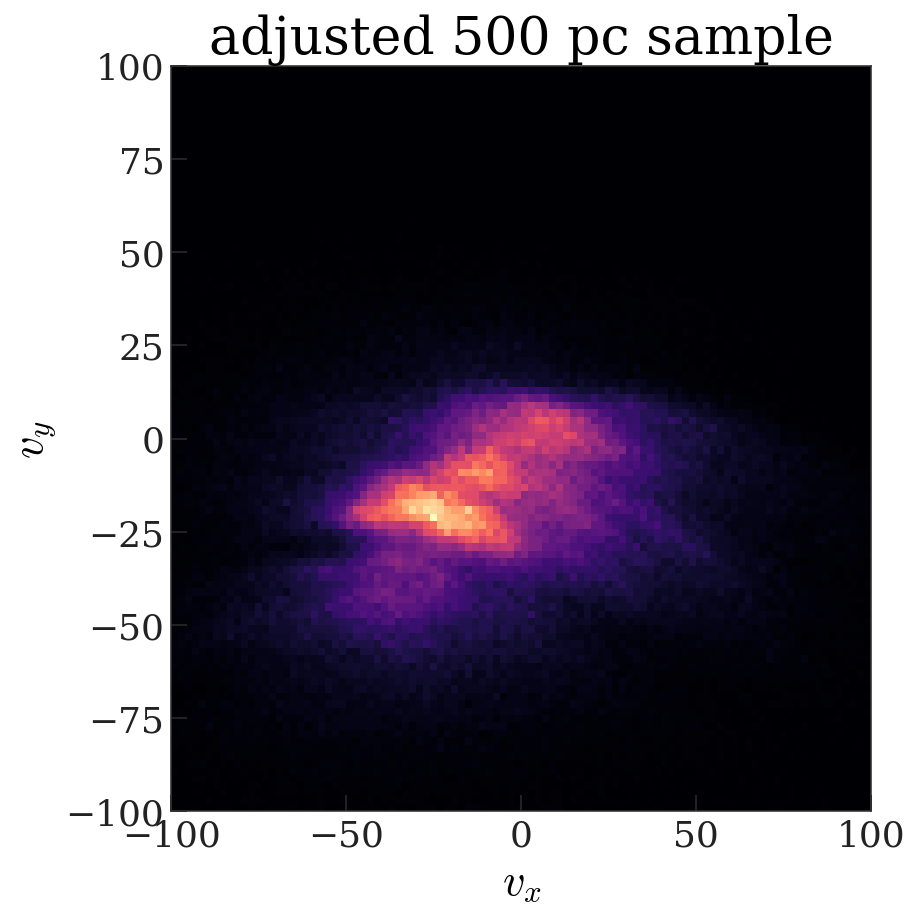

In [36]:
bins = np.arange(-100, 100+1e-3, 2)

Hs = []

mask = disk_vmask & mask_r100 & young_mask
H, xe, ye = np.histogram2d(UVW[mask, 0], 
                           UVW[mask, 1],
                           bins=bins)
Hs.append(H)

fig, ax = plt.subplots(figsize=(6.5, 6.5))
ax.pcolormesh(xe, ye, H.T)
ax.set_xlabel('$v_x$')
ax.set_ylabel('$v_y$')
ax.set_title('local sample')
fig.tight_layout()
fig.set_facecolor('w')

# ---

mask = disk_vmask & mask_r500 & young_mask
model_v = myspace.get_model_v(tensors, UVW[mask], xyz[mask])

H, xe, ye = np.histogram2d(model_v[:, 0], 
                           model_v[:, 1],
                           bins=bins)
Hs.append(H)

fig, ax = plt.subplots(figsize=(6.5, 6.5))
ax.pcolormesh(xe, ye, H.T)
ax.set_xlabel('$v_x$')
ax.set_ylabel('$v_y$')
ax.set_title('adjusted 500 pc sample')
fig.tight_layout()
fig.set_facecolor('w')

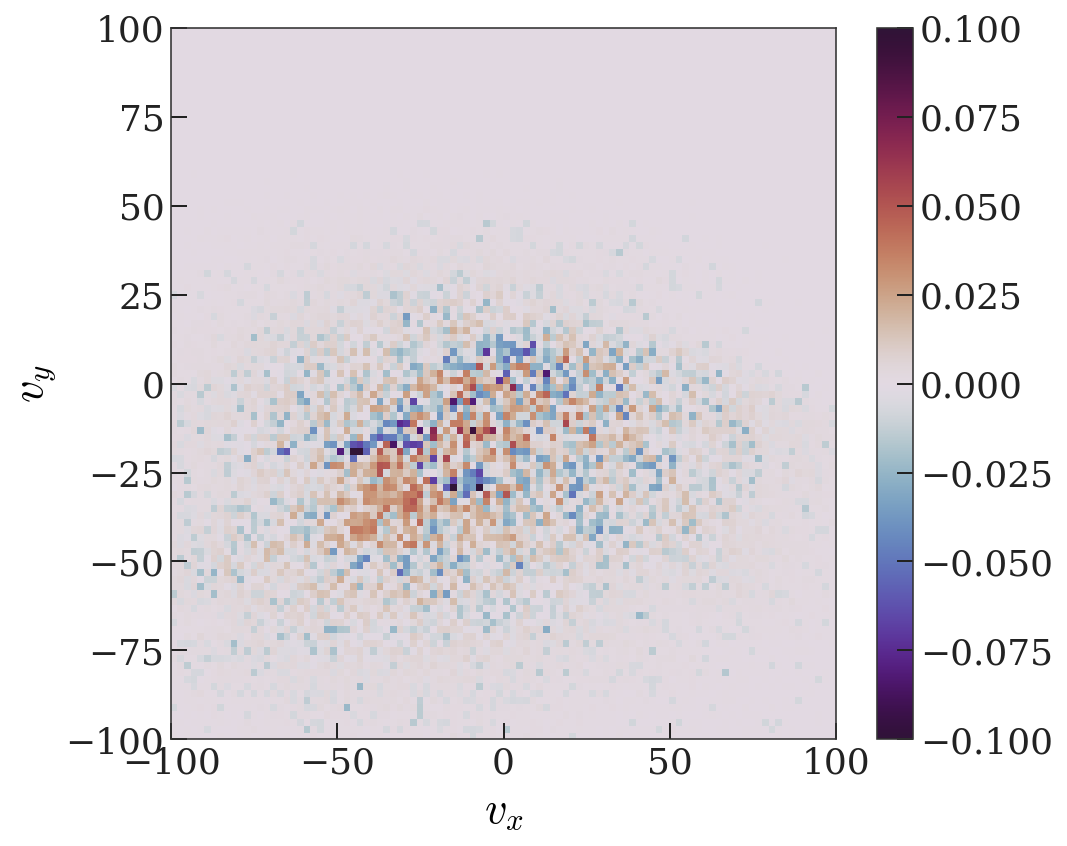

In [37]:
f = Hs[1].sum() / Hs[0].sum()

fig, ax = plt.subplots(figsize=(7.5, 6))
cs = ax.pcolormesh(xe, ye, 100 * (Hs[1]/Hs[1].sum() - Hs[0]/Hs[0].sum()).T,
                   cmap='twilight_shifted', vmin=-1e-1, vmax=1e-1)
fig.colorbar(cs)
ax.set_xlabel('$v_x$')
ax.set_ylabel('$v_y$')
fig.tight_layout()
fig.set_facecolor('w')